# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import pandas as pd
import numpy as np
from tqdm import trange

import torch.nn as nn
import torch.utils.data as data

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import trange
from scipy.stats.stats import pearsonr   

C:\Users\Kelyan\AppData\Local\Temp\ipykernel_17204\1698133606.py:15: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


## Wine

### Load datasets

In [3]:
red_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=';')
white_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep=';')

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Splitting the data into features and target
X_train = red_wine.drop('quality', axis=1).values
y_train = red_wine['quality'].values.reshape(-1, 1) 

X_test, y_test  =  white_wine.drop('quality', axis=1).values, white_wine['quality'].values.reshape(-1, 1) 

y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

dataset_train = torch.utils.data.TensorDataset(X_train_scaled, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test_scaled, y_test)

### Use Deep Evidential Regression

In [5]:
#Required losses to make use of Evidential

def NIG_NLL(y, gamma, v, alpha, beta, device, reduce=True):
    twoBlambda = 2*beta*(1+v)

    nll = 0.5*torch.log(torch.tensor(np.pi).to(device)/v)  \
        - alpha*torch.log(twoBlambda+1e-5)  \
        + (alpha+0.5) * torch.log(v*(y-gamma)**2 + twoBlambda+1e-5)  \
        + torch.lgamma(alpha)  \
        - torch.lgamma(alpha+0.5)

    return nll.mean() if reduce else nll

def KL_NIG(mu1, v1, a1, b1, mu2, v2, a2, b2):
    KL = 0.5*(a1-1)/b1 * (v2*torch.square(mu2-mu1))  \
        + 0.5*v2/v1  \
        - 0.5*torch.log(torch.abs(v2)/torch.abs(v1))  \
        - 0.5 + a2*torch.log(b1/b2)  \
        - (torch.lgamma(a1) - torch.lgamma(a2))  \
        + (a1 - a2)*torch.digamma(a1)  \
        - (b1 - b2)*a1/b1
    return KL

def NIG_Reg(y, gamma, v, alpha, beta, device, omega=0.01, reduce=True, kl=False):
    error = torch.abs(y-gamma).detach()
    if kl:
        kl = KL_NIG(gamma, v, alpha, beta, gamma, device, omega, 1+omega, beta)
        reg = error*kl
    else:
        evi = 2*v+(alpha) #+ 1/beta
        reg = error*evi

    return (reg).mean() if reduce else reg

def EvidentialRegression(y_true, gamma, v, alpha, beta, device ,coef=1.0,reduce=True):
    loss_nll = NIG_NLL(y_true, gamma, v, alpha, beta, device, reduce = reduce)
    loss_reg = NIG_Reg(y_true, gamma, v, alpha, beta, device, reduce = reduce)
    return loss_nll + coef * loss_reg

In [6]:
###Changes
class Regressor(nn.Module):
    def __init__(self,input_shape=64):
        super(Regressor,self).__init__()
        self.model = torch.nn.Sequential(torch.nn.Linear(input_shape, 64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 4), #allways 4 output for evi
                        )

        self.evidence = nn.Softplus()
        
        
    def forward(self,x):
        
        pred = self.model(x)
        pred = pred.view(x.shape[0], -1, 4)

        mu,logv, logalpha, logbeta = [w.squeeze(-1) for w in torch.split(pred, 1, dim=-1)]

        v = self.evidence(logv) + 1e-5
        alpha = self.evidence(logalpha) + 1 +1e-5
        beta = self.evidence(logbeta) + 1e-5
        
        return mu, v, alpha, beta


# Create the model instance
model = Regressor(input_shape=X_train_scaled.shape[1])

mean_loss=1.440275: 100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


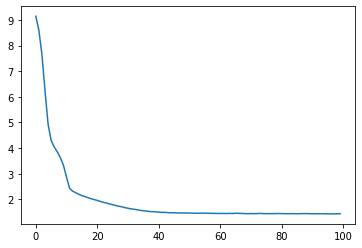

In [7]:
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=36, shuffle=True,  num_workers=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = []
t = trange(100)

for epoch in t:
    epoch_loss = 0.
    model.train()
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()

        gamma_s,v_s,alpha_s,beta_s = model(inputs)
        loss = EvidentialRegression(targets.squeeze(1) ,gamma_s, v_s, alpha_s, beta_s, 'cpu', coef=0.2)

        mean_loss = loss.mean()
        mean_loss.backward()

        epoch_loss += mean_loss

        optimizer.step()

    epoch_loss /= len(train_dataloader)

    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

plt.plot(losses)

In [61]:
def plot_uncertainty(X_test, y_test, model):
    # Predict the evidential outputs using the model
    with torch.no_grad():
        mu, v, alpha, beta  = model(X_test)
    
    # Split the predictions into components
    mu = mu[:, 0].numpy()  # Convert to NumPy array and get the predicted mean
    var = np.sqrt(beta / (v * (alpha - 1))) # Convert to NumPy array and get the predicted variance
    # var = np.minimum(var, 1e2)[:, 0]  # for visualization, cap the variance
    var = var[:, 0]
    var[var > 50] = 0
    # Get the true quality scores as NumPy array for indexing
    y_test_np = y_test.numpy() #if isinstance(y_test, tf.Tensor) else y_test
    
    # Sort the test data by the predicted mean for nicer plots
    sorted_indices = np.argsort(mu)
    mu_sorted = mu[sorted_indices]
    mu_sorted = torch.from_numpy(mu)
    var_sorted = var[sorted_indices]
    #print 10 first values of var_sorted
    print("10 first values of var_sorted", var_sorted[:10])
    print("10 last values of var_sorted", var_sorted[-10:])
    y_test_sorted = y_test_np[sorted_indices]
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(y_test_sorted)), y_test_sorted, s=2., color='blue', zorder=0, label="True Quality")
    plt.scatter(range(len(mu_sorted)), mu_sorted, s=2., color='red', zorder=1, label="Predicted Quality")
    print("var_sorted shape:", var_sorted.shape)
    print("mu shape:", mu_sorted.shape)
    print("var_sorted type:", type(var_sorted))
    print("mu_sorted type:", type(mu_sorted))
    plt.fill_between(range(len(mu_sorted)), mu_sorted + var_sorted, mu_sorted - var_sorted, alpha=0.2, color='red', label="Predicted Std Dev")
    plt.xlabel("Sorted Test Data Points")
    plt.ylabel("Quality")
    plt.title("Wine Quality Predictions with Uncertainty")
    plt.legend()
    plt.show()


In [72]:
def plot_uncertainty(X_test, y_test, model, plot_uncertainty=False):
    # Predict the evidential outputs using the model
    with torch.no_grad():
        mu, v, alpha, beta  = model(X_test)
    
    # Split the predictions into components
    mu = mu[:, 0].numpy()  # Convert to NumPy array and get the predicted mean
    mu = torch.from_numpy(mu)
    var = np.sqrt(beta / (v * (alpha - 1))) # Convert to NumPy array and get the predicted variance
    # var = np.minimum(var, 1e2)[:, 0]  # for visualization, cap the variance
    var = var[:, 0]
    var[var > 50] = 0
    # Get the true quality scores as NumPy array for indexing
    y_test_np = y_test.numpy() #if isinstance(y_test, tf.Tensor) else y_test
    
   # Plotting
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(y_test)), y_test, s=2., color='blue', zorder=0, label="True Quality")
    plt.scatter(range(len(mu)), mu, s=2., color='red', zorder=1, label="Predicted Quality")
    if plot_uncertainty:
        plt.fill_between(range(len(mu)), mu + var, mu - var, alpha=0.2, color='red', label="Predicted Std Dev")
    plt.xlabel("Test Data Points")
    plt.ylabel("Quality")
    plt.title("Wine Quality Predictions with Uncertainty")
    plt.legend()
    plt.show()

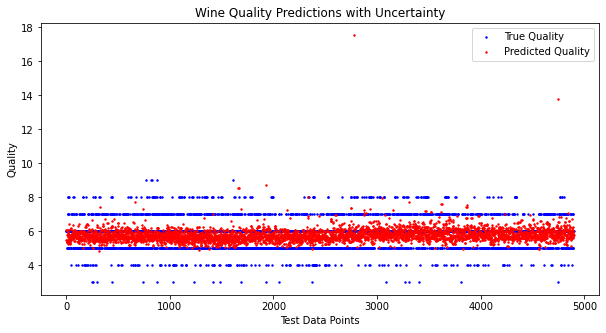

In [73]:
model.eval()
plot_uncertainty(X_test_scaled, y_test, model)

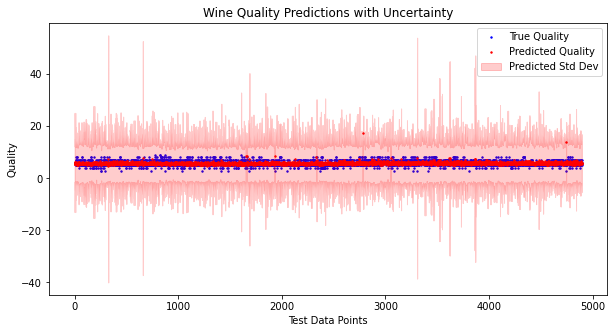

In [74]:
plot_uncertainty(X_test_scaled, y_test, model, plot_uncertainty=True)

In [10]:
def plot_uncertainty_vs_error(X_test_scaled, y_test, model):
    # Predict the evidential outputs using the model
    with torch.no_grad():
        mu, v, alpha, beta = model(X_test_scaled)
    
    mu = mu[:, 0].numpy()  # Convert to NumPy array and get the predicted mean
    var = np.sqrt(beta / (v * (alpha - 1))) # Convert to NumPy array and get the predicted variance
    var = np.minimum(var, 1e3)[:, 0]  # for visualization, cap the variance
    
    # Get the true quality scores as NumPy array for indexing
    y_test_np = y_test.numpy() #if isinstance(y_test, tf.Tensor) else y_test

    # transform y_test_np to 1D array
    y_test_np = y_test_np.flatten()

    pred_error = np.abs(y_test_np - mu)

    # Plot the correlation between the predicted standard deviation var and the prediction error (|y_test_np - mu|)
    plt.figure(figsize=(6, 6))
    plt.scatter(var, pred_error, s=2., color='blue', label="Uncertainty vs. Error")
    plt.xlabel("Predicted Standard Deviation")
    plt.ylabel("Prediction Error")
    plt.title("Uncertainty vs. Error")
    plt.show()

    return (var, pred_error, mu)

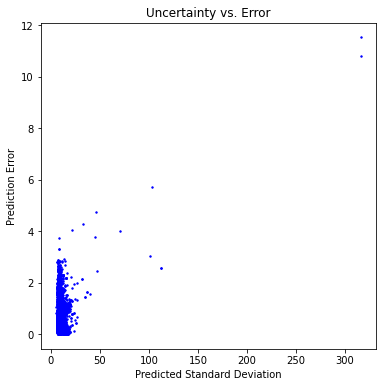

In [11]:
var, pred_error,mu = plot_uncertainty_vs_error(X_test_scaled, y_test, model)

In [12]:
# compute the correlation between var and pred_error
print(pearsonr(var,pred_error))

(0.3567797462130539, 5.642314612611703e-147)


In [13]:
nll_loss = 0.5 * np.log(2 * torch.pi * var) + (y_test - mu) ** 2 / (2 * var)
nll_loss = nll_loss.mean()

print(f'Negative Log Likelihood Loss on the Test Set of the Wine Dataset using Evidential Deep Learning: {nll_loss.item()}')

Negative Log Likelihood Loss on the Test Set of the Wine Dataset using Evidential Deep Learning: 2.087883710861206
